### DAS Tutorial

#### DAS Metadata examination

In [1]:
# import necessary dependencies
import h5py, os, sys, datetime, re
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# define path
root = Path.cwd().parent
DAS_path = os.path.join(root, 'data', 'DAS', 'data_1HZ')

In [3]:
# example DAS file
DAS_test = os.path.join(DAS_path, 'decimator3_2023-08-10_06.42.19_UTC.h5')

In [4]:
# examine the DAS file
with h5py.File(DAS_test, 'r') as h5_file:
    # list all groups and datasets
    def print_structure(name, obj):
        if isinstance(obj, h5py.Group):
            print(f"Group: {name}")
        elif isinstance(obj, h5py.Dataset):
            print(f"Dataset: {name} - shape: {obj.shape}, dtype: {obj.dtype}")

    print("File Structure:")
    h5_file.visititems(print_structure)

File Structure:
Group: Acquisition
Group: Acquisition/Raw[0]
Dataset: Acquisition/Raw[0]/RawData - shape: (3600, 1587), dtype: float32
Dataset: Acquisition/Raw[0]/RawDataSampleCount - shape: (3600,), dtype: int64
Dataset: Acquisition/Raw[0]/RawDataTime - shape: (3600,), dtype: int64


In [5]:
with h5py.File(DAS_test, 'r') as h5_file:
    # access datasets
    raw_data = h5_file['Acquisition/Raw[0]/RawData'][:]
    raw_time = h5_file['Acquisition/Raw[0]/RawDataTime'][:]
    attrs_rec = dict(h5_file['Acquisition'].attrs)

In [6]:
# metadata
attrs_rec

{'AcquisitionId': b'RunName/RunNumber',
 'BandDataMaxUserValue': 0.0,
 'BandDataMinUserValue': 0.0,
 'Build': b'5.19.6_P',
 'CommitHash': b'e0de8303',
 'DasInstrumentBox': b'ONYXONYX-0186',
 'DetectionAccuracy': b'Not Applicable',
 'FFID': 0,
 'FacilityId': b'WellName1',
 'FiberID': 1,
 'GaugeLength': 4.785714402601981,
 'GaugeLengthUnit': b'm',
 'Hostname': b'ONYX-0186',
 'MaximumFrequency': 0.5,
 'MeasurementStartTime': b'2023-08-10T06:42:19.000000+00:00',
 'MinimumFrequency': 0.0,
 'NumberOfLoci': 1587,
 'OpticalPath': b'OpticalPath',
 'PulseRate': 1.0,
 'PulseRateUnit': b'Hz',
 'PulseWidth': 20.0,
 'PulseWidthUnit': b'ns',
 'SoftwareVersion': b'7320',
 'SpatialSamplingInterval': 4.785714402601981,
 'SpatialSamplingIntervalUnit': b'm',
 'StartLocusIndex': 0,
 'SystemType': b'Xavier',
 'TriggeredMeasurement': 0,
 'VendorCode': b'Vendor',
 'schemaVersion': b'2.0',
 'uuid': b'072d1164-2cd9-4da2-9460-bbee1e873935'}

In [7]:
# important metadata
gauge_length = attrs_rec['GaugeLength']
total_Loci = attrs_rec['NumberOfLoci'] # or the number of channels;
                                       # each locus corresponds to a spatial location where 
                                       # strain or vibration data is recorded.
sampling_rate = attrs_rec['PulseRate'] # the frequency at which optical pulses are sent into the fiber and data is recorded.

print(f'Gauge Length is {gauge_length} m.')
print(f'There are {total_Loci} channels.')
print(f'Sampling rate is {sampling_rate} Hz.')

Gauge Length is 4.785714402601981 m.
There are 1587 channels.
Sampling rate is 1.0 Hz.


#### Useful functions

In [8]:
def sintela_to_datetime(sintela_times):
    '''returns a datetime.datetime object if input is a Numpy integer,
       or an array of datetime.datetime objects if input is a NumPy array'''

    # Check if input is a single integer
    if isinstance(sintela_times, np.integer):
        return datetime.datetime.fromtimestamp(sintela_times / 1e6, tz=datetime.timezone.utc)
    # Check if input is a NumPy array
    elif isinstance(sintela_times, np.ndarray):
        # Apply datetime.datetime.fromtimestamp() with UTC timezone to all entries of the array
        datetime_arr = np.vectorize(lambda t: datetime.datetime.fromtimestamp(t / 1e6, tz=datetime.timezone.utc))(sintela_times)
        return datetime_arr
    else:
        raise ValueError("Input must be either a single NumPy integer or a NumPy array")


In [9]:
def get_Onyx_file_time(file):
    '''Find timestamp in Onyx file name.'''
    # Define regular expression pattern to match date and time components
    pattern = r'.*(\d{4})\D+(\d{1,2})\D+(\d{1,2})\D+(\d{1,2})\D+(\d{1,2})\D+(\d{1,2}).*'
    filename = os.path.basename(file)
    # Extract date and time components using regular expression
    match = re.match(pattern, filename)
    if match:
        # Extract matched groups
        groups = match.groups()
        # Convert matched groups to integers
        year, month, day, hour, minute, second = map(int, groups)
        # Create datetime object
        datetime_obj = datetime.datetime(year, month, day, hour, minute, second)
        return datetime_obj
    else:
        print("Invalid datetime format")
        return None

In [10]:
print(f'epoch format: {raw_time}\n') # Unix epoch format (seconds since January 1, 1970); in microseconds
time = sintela_to_datetime(raw_time)
print(f'UTC datetime: {time}')

epoch format: [1691649739000000 1691649740000000 1691649741000000 ... 1691653336000000
 1691653337000000 1691653338000000]

UTC datetime: [datetime.datetime(2023, 8, 10, 6, 42, 19, tzinfo=datetime.timezone.utc)
 datetime.datetime(2023, 8, 10, 6, 42, 20, tzinfo=datetime.timezone.utc)
 datetime.datetime(2023, 8, 10, 6, 42, 21, tzinfo=datetime.timezone.utc)
 ...
 datetime.datetime(2023, 8, 10, 7, 42, 16, tzinfo=datetime.timezone.utc)
 datetime.datetime(2023, 8, 10, 7, 42, 17, tzinfo=datetime.timezone.utc)
 datetime.datetime(2023, 8, 10, 7, 42, 18, tzinfo=datetime.timezone.utc)]


In [11]:
datetime_from_file = get_Onyx_file_time('decimator3_2023-08-10_06.42.19_UTC.h5')
datetime_from_file

datetime.datetime(2023, 8, 10, 6, 42, 19)

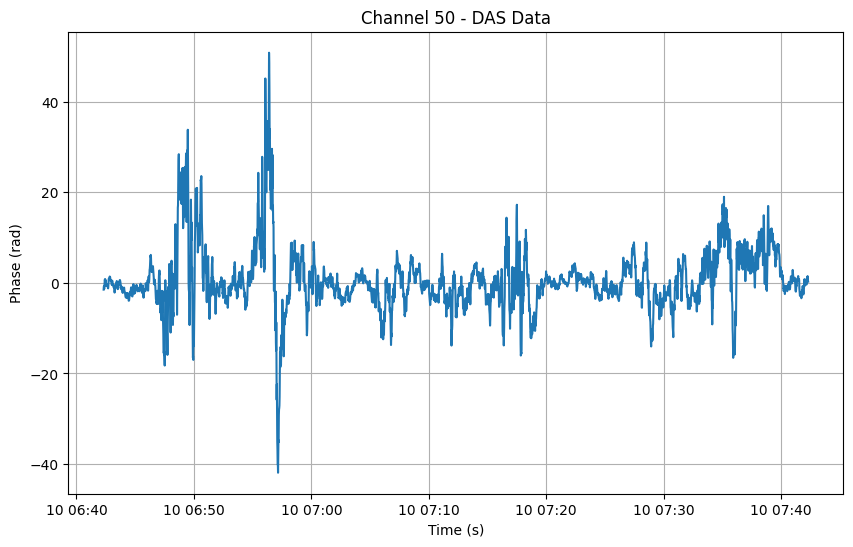

In [12]:
# choose a channel to plot (e.g., channel 50)
channel = 50

plt.figure(figsize=(10, 6))
plt.plot(time, raw_data[:, channel])
plt.title(f"Channel {channel} - DAS Data")
plt.xlabel("Time (s)")
plt.ylabel("Phase (rad)")
plt.grid()
plt.show()